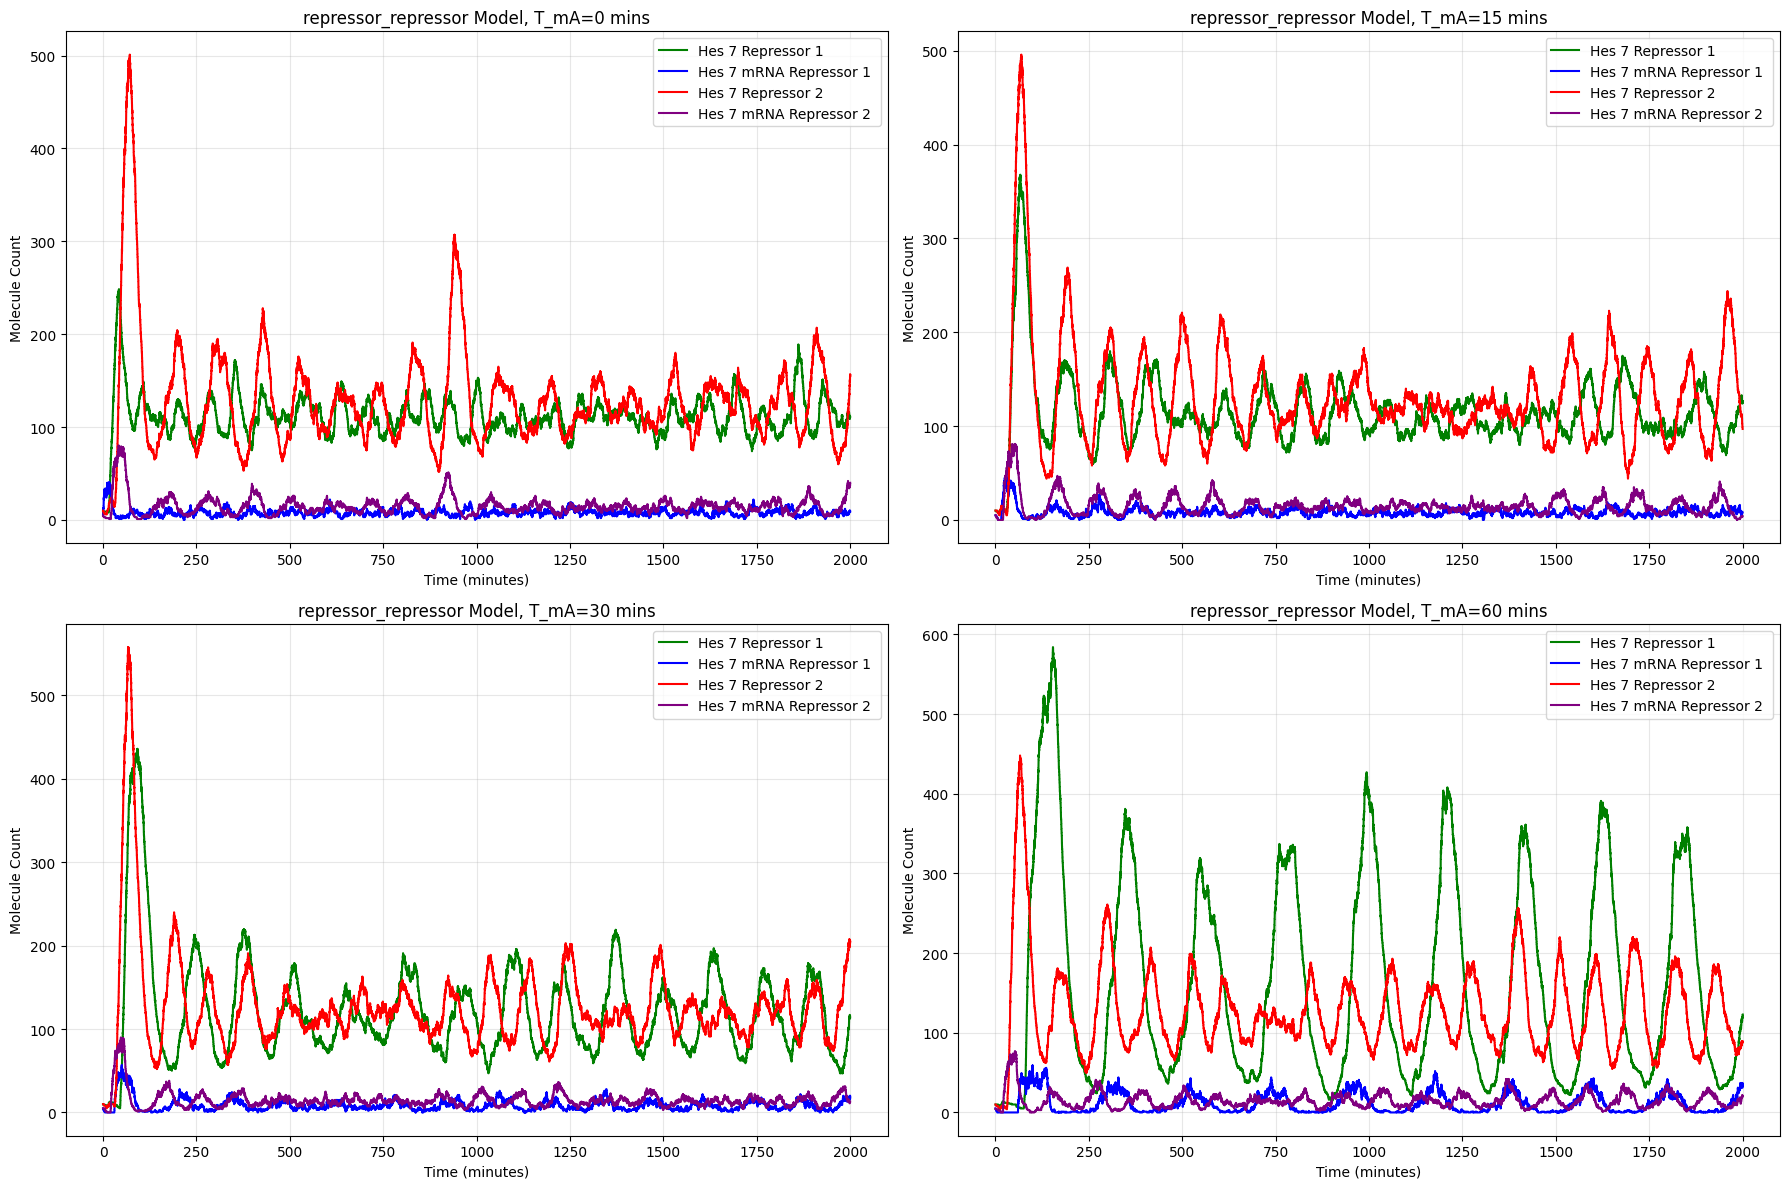

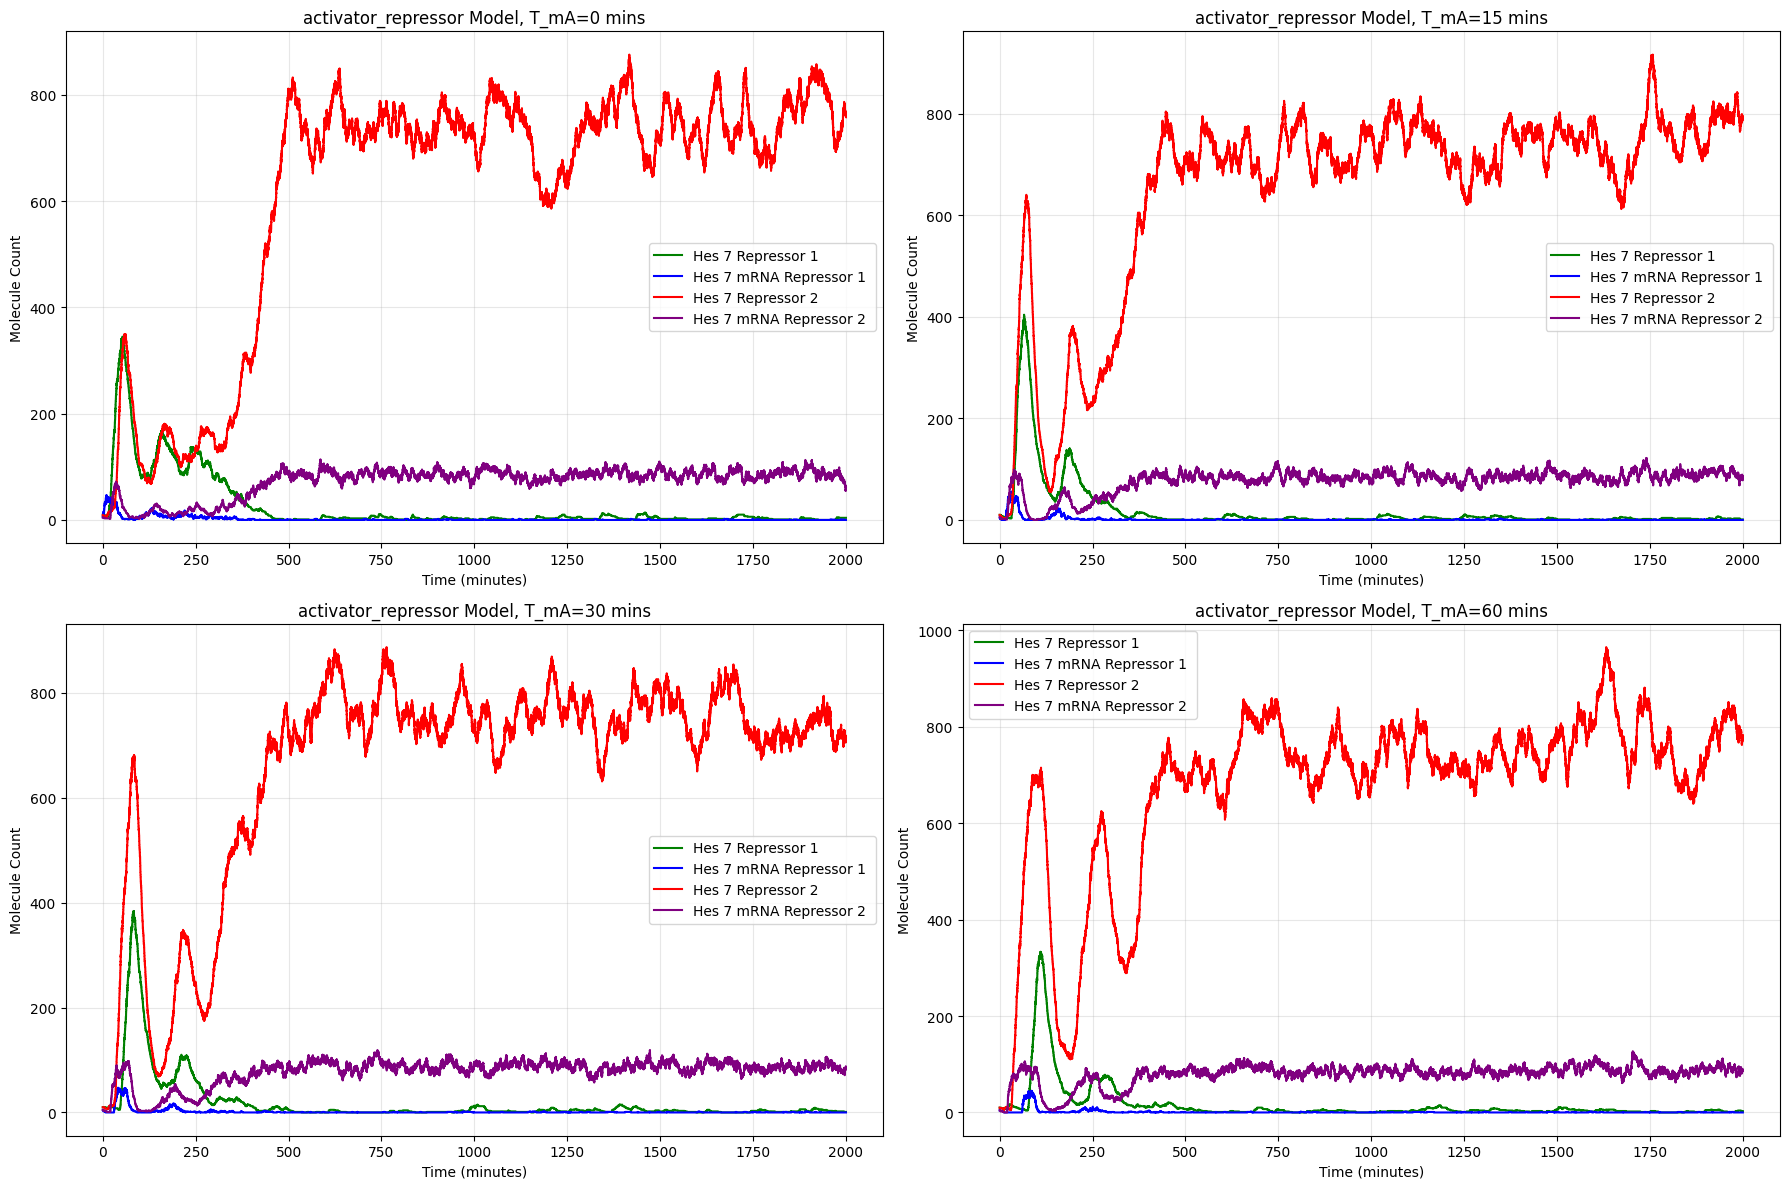

In [1]:
import math
import numpy as np
import heapq
import matplotlib.pyplot as plt


def execute_delayed_events(current_time, event_queue, state):
    while event_queue and event_queue[0][0] <= current_time:
        event_time, event_type, state_change = heapq.heappop(event_queue)
        for molecule, change in state_change.items():
            state[molecule] = max(state[molecule] + change, 0)
    return state

def schedule_event(event_queue, event_time, event_type, state_change):
    heapq.heappush(event_queue, (event_time, event_type, state_change))

def calculate_propensities(state, params, model_type):
    A, mA, R, mR = state['A'], state['mA'], state['R'], state['mR']
    k, Pcrit, a, r_translate = params['k'], params['Pcrit'], params['a'], params['r_translate']
    
    if model_type == "repressor_repressor":
        # repressor + repressor
        f_A = k / (1 + (R / Pcrit)**2)  # A repressed by R
        f_R = k / (1 + (A / Pcrit)**2)  # R repressed by A
    elif model_type == "activator_repressor":
        # activator + repressor
        f_A = k / (1 + (A / Pcrit)**2)  # R repressed by A
        f_R = k / (1 + (R / Pcrit)**2)  # A repressed by R
    
    return {
        'transcribe_mA': f_R,
        'transcribe_mR': f_A,
        'translate_A': a * mA,
        'translate_R': r_translate * mR,
        'deg_mA': (math.log(2)/params['tau_mA']) * mA,
        'deg_A': (math.log(2)/params['tau_A']) * A,
        'deg_mR': (math.log(2)/params['tau_mR']) * mR,
        'deg_R': (math.log(2)/params['tau_R']) * R
    }

# Parameters for both models
params = {
    'T_A': 15,       # Translational delay for A (minutes)
    'T_R': 10,       # Translational delay for R
    'T_mR': 20,      # Transcriptional delay for mR
    'a': 0.5,        # Translation rate for A
    'r_translate': 0.4,  # Translation rate for R
    'k': 10,         # Basal transcription rate
    'Pcrit': 50,     # Inhibition threshold
    'tau_A': 20,     # Protein A half-life (minutes)
    'tau_mA': 3,     # mRNA A half-life
    'tau_R': 15,     # Protein R half-life
    'tau_mR': 6      # mRNA R half-life
}

# transcriptional delays 
Tms = [0, 15, 30, 60]  

def simulate_and_plot(model_type, Tms):
    plt.figure(figsize=(18, 12))
    for i, tm in enumerate(Tms):
        params['T_mA'] = tm
        
        # Initial state
        state = {'A': 10, 'mA': 5, 'R': 10, 'mR': 5}
        event_queue = []
        current_time = 0
        end_time = 2000  

        time_history, A_history, mA_history, R_history, mR_history = [], [], [], [], []

        # # Gillespie simulation loop
        while current_time < end_time:
            state = execute_delayed_events(current_time, event_queue, state)
            propensities = calculate_propensities(state, params, model_type)
            total_rate = sum(propensities.values())
            
            if total_rate == 0:
                break
            
            tau = np.random.exponential(1/total_rate)
            current_time += tau
            
            rand = np.random.uniform()
            cumulative = 0
            for reaction, rate in propensities.items():
                cumulative += rate
                if rand <= cumulative/total_rate:
                    if reaction == 'transcribe_mA':
                        schedule_event(event_queue, current_time + params['T_mA'], 'add_mA', {'mA': 1})
                    elif reaction == 'transcribe_mR':
                        schedule_event(event_queue, current_time + params['T_mR'], 'add_mR', {'mR': 1})
                    elif reaction == 'translate_A':
                        schedule_event(event_queue, current_time + params['T_A'], 'add_A', {'A': 1})
                    elif reaction == 'translate_R':
                        schedule_event(event_queue, current_time + params['T_R'], 'add_R', {'R': 1})
                    elif reaction.startswith('deg_'):
                        molecule = reaction.split('_')[1]
                        state[molecule] = max(state[molecule] - 1, 0)
                    break
            
            time_history.append(current_time)
            A_history.append(state['A'])
            mA_history.append(state['mA'])
            R_history.append(state['R'])
            mR_history.append(state['mR'])

        # Plot
        plt.subplot(2, 2, i+1)
        plt.step(time_history, A_history, where='post', label='Hes 7 Repressor 1', color='green')
        plt.step(time_history, mA_history, where='post', label='Hes 7 mRNA Repressor 1 ', color='blue')
        plt.step(time_history, R_history, where='post', label='Hes 7 Repressor 2', color='red')
        plt.step(time_history, mR_history, where='post', label='Hes 7 mRNA Repressor 2', color='purple')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Molecule Count')
        plt.title(f'{model_type} Model, T_mA={tm} mins')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
#only the repressor model was used in the presentation and report
simulate_and_plot("repressor_repressor", Tms)
simulate_and_plot("activator_repressor", Tms)